In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import os
import numpy as np
import pandas as pd
from copy import deepcopy
from typing import List, Tuple, Dict, Callable
import seaborn as sns
import requests
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial.distance import euclidean
from itertools import permutations, combinations
from joblib import load
import importlib
from time import time

#from numba import jit, cuda

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model


from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline

from spine.models.dice_gradients import DiceCounterfactual
from spine.data.load_data import *

import spine.models.visualization.create_map_embedding as create_map_embedding
from spine.models.transformers.ssnp import SSNP

import skdim
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

Num GPUs Available:  1


c:\Users\imke.bloemen\AppData\Local\anaconda3\envs\jan-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

bc = pd.DataFrame(X, columns=breast_cancer.feature_names)

In [41]:
# Identify continuous columns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import regularizers
continuous_columns = breast_cancer.feature_names
print(f"Continuous columns: {continuous_columns}")

dataset_continuous = bc[continuous_columns]

bc['label'] = y
continuous_columns = np.append(continuous_columns, "label")

n_classes = np.unique(y).shape[0]

dataset_continuous['label'] = y
dataset_continuous = dataset_continuous.drop(columns=["label"]) if "label" in dataset_continuous.columns else dataset_continuous
dataset_continuous = dataset_continuous.reset_index(drop=True)

dataset_continuous.to_csv( "../../../data/raw/breast_cancer.csv", index=False)

Continuous columns: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

np.save("../../../data//breast_cancer/train_test_0/X_train.npy", X_train)
np.save("../../../data/experiment_input/breast_cancer/train_test_0/X_test.npy", X_test)
np.save("../../../data/experiment_input/breast_cancer/train_test_0/y_train.npy", y_train)
np.save("../../../data/experiment_input/breast_cancer/train_test_0/y_test.npy", y_test)

y_train_one_hot = to_categorical(y_train, num_classes=n_classes)
y_test_one_hot = to_categorical(y_test, num_classes=n_classes)

clf = Sequential([
        Dense(64, activation='relu', 
              input_shape=(X_train.shape[1],),
              kernel_regularizer=regularizers.l2(1e-4)),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-2)),
        Dense(2, activation='softmax')
    ])

start = time()
clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = clf.fit(
X_train, y_train_one_hot,
batch_size=5,
epochs=20,
validation_split=0.2)

output_dir = "../models/input_classifiers"
dataset_name = "breast_cancer"

loss, accuracy = clf.evaluate(X_test, y_test_one_hot, verbose=0)
print("\tAccuracy on test data: ", [loss, accuracy])
endtime = time() - start
with open(os.path.join(output_dir, dataset_name, f"MLP_0.txt"), "w") as f:
    f.write(f"Accuracy on test data: {[loss, accuracy]}\n")
    f.write(f"Finished training classifier... {endtime}\n")
model_save_path = os.path.join(output_dir, dataset_name, f"MLP_0.h5")
# dump(clf, model_save_path)
clf.save(model_save_path)
print(f"Model saved to {model_save_path}")

Epoch 1/20
73/73 [==============================] - 1s 7ms/step - loss: 1.0143 - accuracy: 0.7995 - val_loss: 0.7299 - val_accuracy: 0.9121
Epoch 2/20
73/73 [==============================] - 0s 4ms/step - loss: 0.5677 - accuracy: 0.8709 - val_loss: 0.4395 - val_accuracy: 0.9341
Epoch 3/20
73/73 [==============================] - 0s 3ms/step - loss: 0.3960 - accuracy: 0.8929 - val_loss: 0.3266 - val_accuracy: 0.9560
Epoch 4/20
73/73 [==============================] - 0s 3ms/step - loss: 0.3079 - accuracy: 0.9231 - val_loss: 0.2611 - val_accuracy: 0.9560
Epoch 5/20
73/73 [==============================] - 0s 3ms/step - loss: 0.2773 - accuracy: 0.9203 - val_loss: 0.2661 - val_accuracy: 0.9560
Epoch 6/20
73/73 [==============================] - 0s 4ms/step - loss: 0.2287 - accuracy: 0.9451 - val_loss: 0.2010 - val_accuracy: 0.9560
Epoch 7/20
73/73 [==============================] - 0s 3ms/step - loss: 0.2110 - accuracy: 0.9478 - val_loss: 0.1831 - val_accuracy: 0.9670
Epoch 8/20
73/73 [==

In [44]:
from sklearn.metrics import classification_report

print("Test Accuracy:", accuracy)
y_pred = np.argmax(clf.predict(X_test), axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9649122953414917
4/4 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        42
           1       0.95      1.00      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



In [ ]:
total_cfs = 1
num_samples = 3
dice_cf = DiceCounterfactual(dataset_name='breast_cancer', 
                             data_columns=continuous_columns,
                             model_name='breast_cancer', 
                             outcome_name='label', 
                             preprocessing=None, 
                             backend='TF2', 
                             model_format='h5',
                            multi_class=True, 
                            comparison=False, 
                            comparison_method='train_test',
                            tt_number='0',
                            classifier_name='MLP',
                            comparison_data_name='breast_cancer'
                            )

train_test
True
Epoch 1/50
2/2 [==============================] - 1s 167ms/step - loss: 0.8847 - val_loss: 0.8150
Epoch 2/50
2/2 [==============================] - 0s 32ms/step - loss: 0.8114 - val_loss: 0.7601
Epoch 3/50
2/2 [==============================] - 0s 38ms/step - loss: 0.7550 - val_loss: 0.7089
Epoch 4/50
2/2 [==============================] - 0s 52ms/step - loss: 0.7046 - val_loss: 0.6689
Epoch 5/50
2/2 [==============================] - 0s 37ms/step - loss: 0.6632 - val_loss: 0.6316
Epoch 6/50
2/2 [==============================] - 0s 29ms/step - loss: 0.6237 - val_loss: 0.5957
Epoch 7/50
2/2 [==============================] - 0s 26ms/step - loss: 0.5891 - val_loss: 0.5658
Epoch 8/50
2/2 [==============================] - 0s 33ms/step - loss: 0.5585 - val_loss: 0.5349
Epoch 9/50
2/2 [==============================] - 0s 23ms/step - loss: 0.5270 - val_loss: 0.5073
Epoch 10/50
2/2 [==============================] - 0s 32ms/step - loss: 0.4972 - val_loss: 0.4781
Epoch 11/50


In [ ]:
path = '../../../results/experiment_output/breast_cancer_newest_eval'
os.makedirs(path, exist_ok=True)

15/15 [==============================] - 0s 3ms/step
Mean Reconstruction MSE: 0.02265284727272272
Mean Reconstruction MAE: 0.11217023465273984
Reconstruction samples saved
15/15 [==============================] - 0s 2ms/step
Latent space visualization saved
Reconstruction error plot saved
Correlation between original and reconstructed features saved


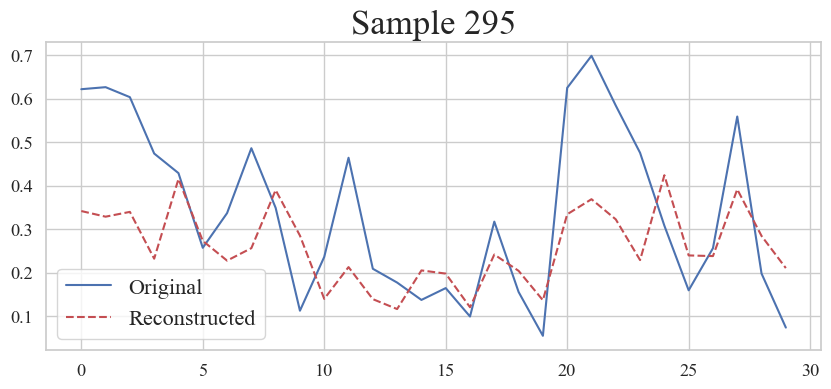

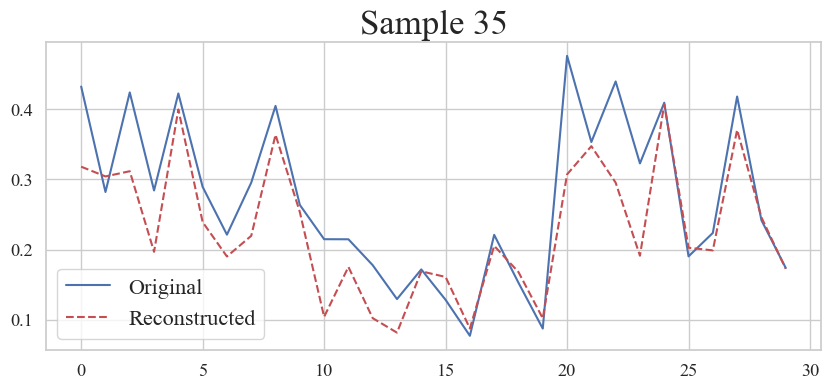

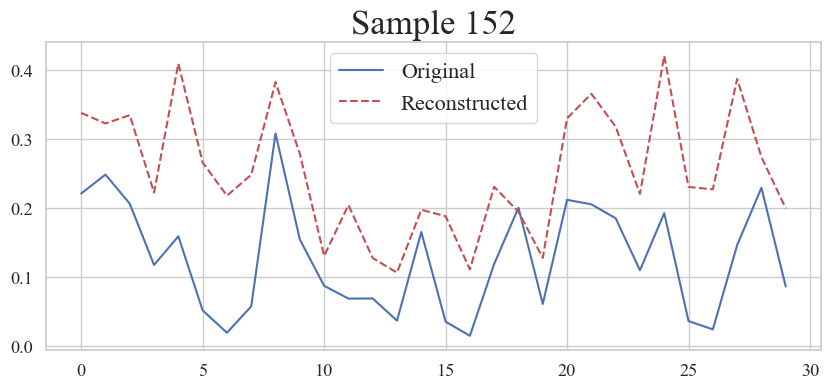

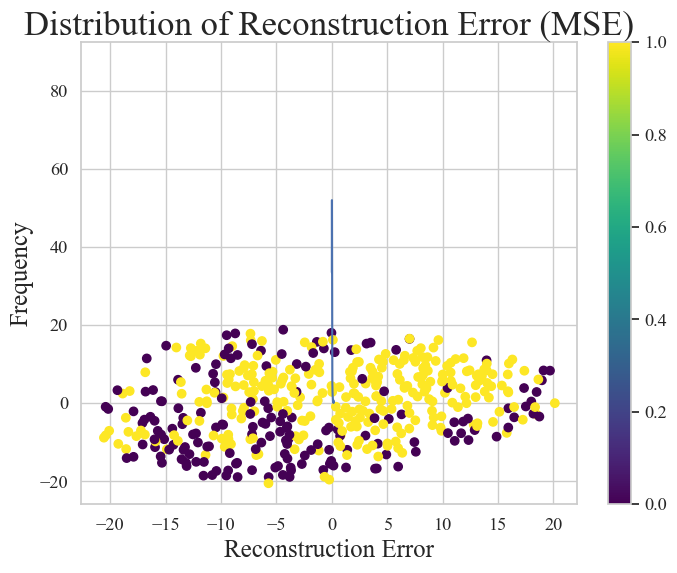

In [50]:
dice_cf.evaluate_autoencoder(save_path=path)

In [68]:
counterfactuals, dataset, predictions_dataset, intermediate_y_pred, dice_data, cf_points_binary, sampled_indices, sampled_predictions, intermediate_points, instance_interest_idxs, counterfactual_idxs, all_gradients, gradient_instance_interest_idxs, gradient_counterfactual_idxs, iterations, class_paths = dice_cf.fit_transform_all_gradient(num_samples=num_samples, 
                                                                                                                                                                                                                                                                                                                                                    total_cfs=total_cfs, 
                                                                                                                                                                                                                                                                                                                                                    desired_class='opposite', 
                                                                                                                                                                                                                                                                                                                                                    prediction_weight=1.5, 
                                                                                                                                                                                                                                                                                                                                                    ae_weight=0.5, 
                                                                                                                                                                                                                                                                                                                                                    proto_weight=0.7, 
                                                                                                                                                                                                                                                                                                                                                    samples=None, 
                                                                                                                                                                                                                                                                                                                                                    learning_rate=0.01,
                                                                                                                                                                                                                                                                                                                                                    min_iter=10)

15/15 [==============================] - 0s 2ms/step
Sampled indices: [409 216 293]
Processing #0 instance 409... with prediction [0.9658996  0.03410047]
Generating counterfactuals for current class 0 and target class 1...
Generation of counterfactuals started...
Initial prediction for query instance: [0.7174401  0.28255987]
Target class defined: 1
step 1,  loss=1.95951
Converged because all CFs have reached the target class and probability.
Diverse Counterfactuals found! total time taken: 00 min 00 sec
Generation of counterfactuals completed.
Processing #1 instance 216... with prediction [0.90348977 0.09651024]
Generating counterfactuals for current class 0 and target class 1...
Generation of counterfactuals started...
Initial prediction for query instance: [0.69146544 0.3085345 ]
Target class defined: 1
step 1,  loss=1.7686
Converged because all CFs have reached the target class and probability.
Diverse Counterfactuals found! total time taken: 00 min 00 sec
Generation of counterfactu

In [69]:
_, model_for_predictions = load_model_dice('TF2', model_name='breast_cancer', tt_number='0', classifier_name='MLP', comparison_method_name=None)

None
True


In [53]:
dice_cf.save_data(path, version='0')

Original data saved to ../../../experiment_output/lamp/breast_cancer_newest_eval\_original_0.csv
Counterfactuals saved to ../../../experiment_output/lamp/breast_cancer_newest_eval\_counterfactuals_0.csv
Intermediate gradient points saved to ../../../experiment_output/lamp/breast_cancer_newest_eval\_intermediate_gradients_0.csv
All gradients saved to ../../../experiment_output/lamp/breast_cancer_newest_eval\_all_gradients_0.csv


In [ ]:
predictions_dataset_output = [np.argmax(x) for x in predictions_dataset]
intermediate_y_pred_output = [np.argmax(x) for x in intermediate_y_pred]
pred_map = create_map_embedding.PredictionMap(grid_size=300, 
                                              original_data=dataset, 
                                              intermediate_gradient_points=intermediate_points, 
                                              counterfactuals=counterfactuals, 
                                              all_gradients=all_gradients, 
                                              number_of_neighbors=3, 
                                              model_for_predictions=model_for_predictions, 
                                              projection_method='lamp', 
                                              projection_name='breast_cancer', 
                                              intermediate_predictions=np.array(intermediate_y_pred_output), 
                                              original_predictions=np.array(predictions_dataset_output), 
                                              counterfactual_predictions=np.array(cf_points_binary), 
                                              outcome_name='label', 
                                              n_classes=2, 
                                              version='MLP', 
                                              comparison=False,
                                              dataset_name='breast_cancer',
                                              gradients=True)

colormap: <matplotlib.colors.ListedColormap object at 0x000002DF18D43A60>


Lamp took 0:00:00.884835 to execute
Original data projected to 2D.
Grid created.
Plot saved as ../../../experiment_output/lamp/breast_cancer_newest_eval\MLP_predicted_points.png.
Plot saved as ../../../experiment_output/lamp/breast_cancer_newest_eval\MLP_original_data_points.png.


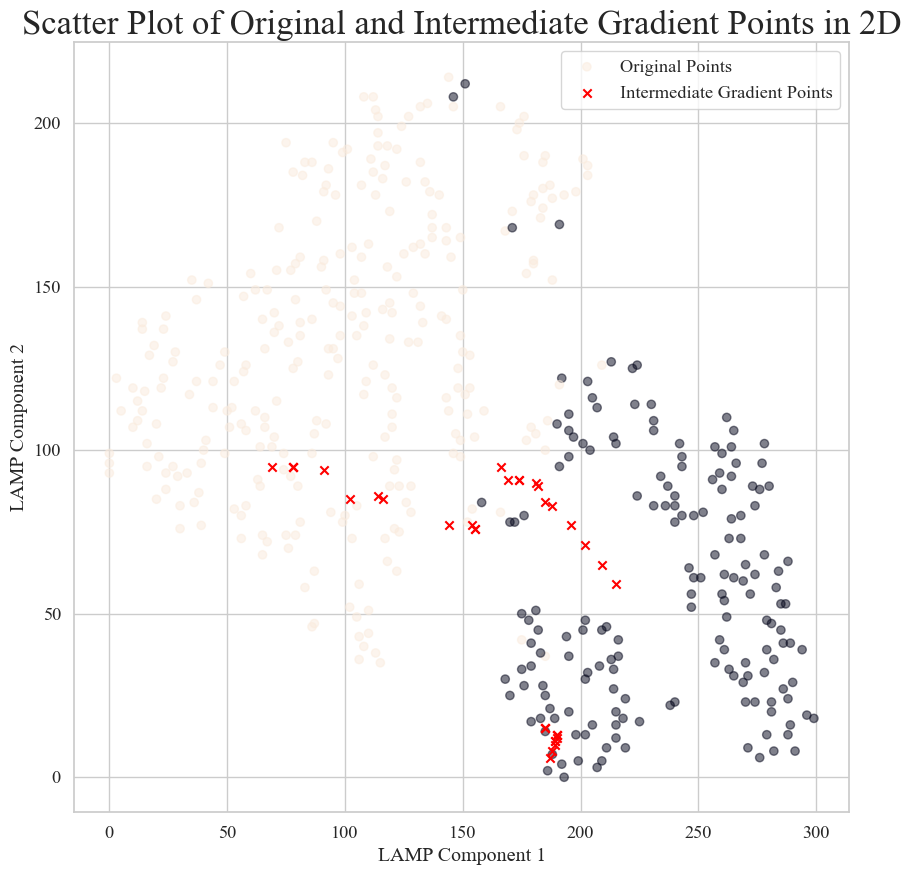

In [ ]:
pred_map.fit_points_2D(path=path)'

Constructing KDTree in LAMP space with combined data...
KDTree constructed.
4/4 [==============================] - 0s 2ms/step
Processed 0 / 90000 grid points.
4/4 [==============================] - 0s 284us/step
Processed 1000 / 90000 grid points.
4/4 [==============================] - 0s 2ms/step
Processed 2000 / 90000 grid points.
4/4 [==============================] - 0s 2ms/step
Processed 3000 / 90000 grid points.
4/4 [==============================] - 0s 1ms/step
Processed 4000 / 90000 grid points.
4/4 [==============================] - 0s 0s/step
Processed 5000 / 90000 grid points.
4/4 [==============================] - 0s 6ms/step
Processed 6000 / 90000 grid points.
4/4 [==============================] - 0s 0s/step
Processed 7000 / 90000 grid points.
4/4 [==============================] - 0s 128us/step
Processed 8000 / 90000 grid points.
4/4 [==============================] - 0s 2ms/step
Processed 9000 / 90000 grid points.
4/4 [==============================] - 0s 0s/step
Proce

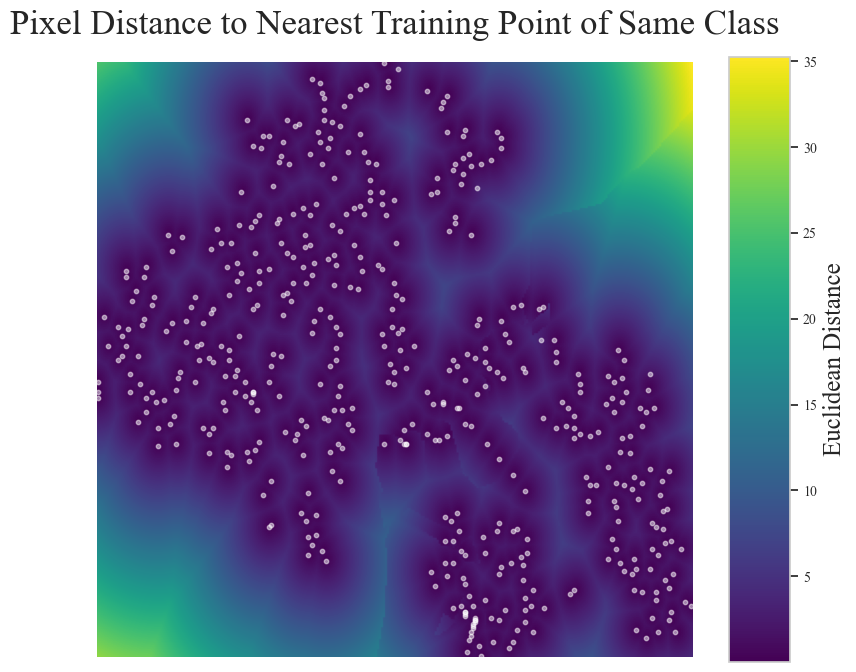

In [ ]:
pred_map.fit_grid_knn_weighted_interpolation(path=path)

In [73]:
pred_map.plot_original_data_points(path=path, grid_lines=False)

Plot saved as ../../../experiment_output/lamp/breast_cancer_newest_eval\MLP_original_data_points.png.


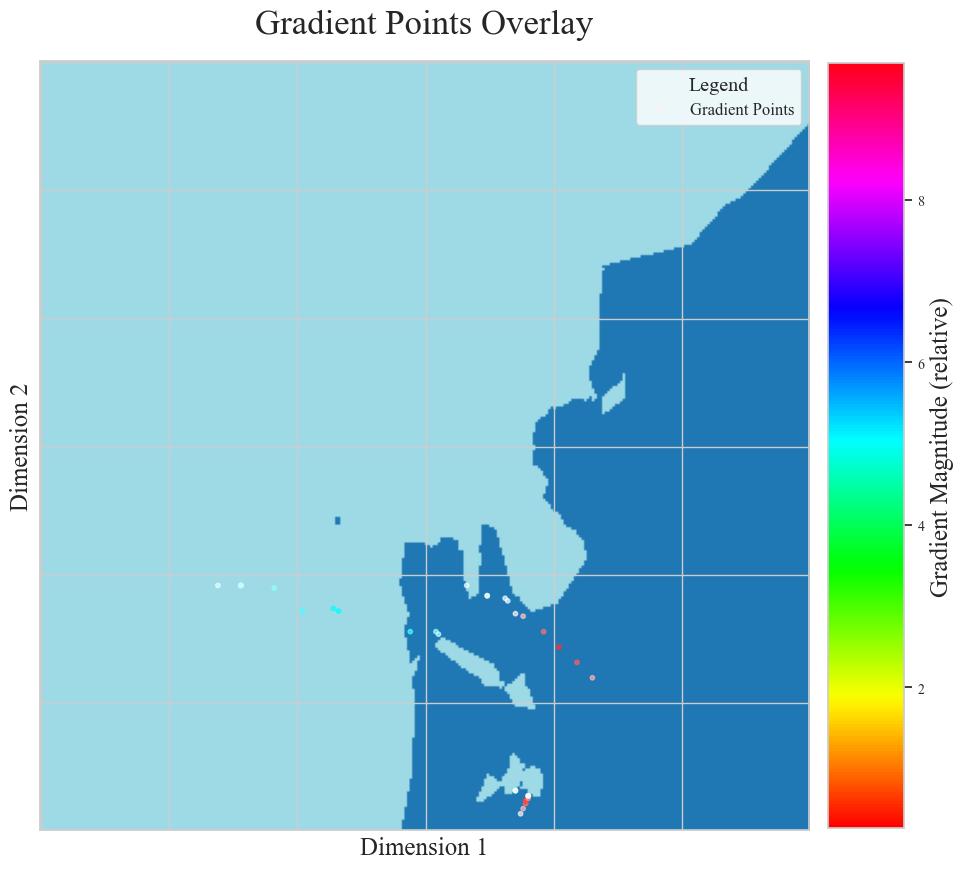

In [74]:
pred_map.plot_gradient(path=path)

1/1 [==============================] - 0s 22ms/step


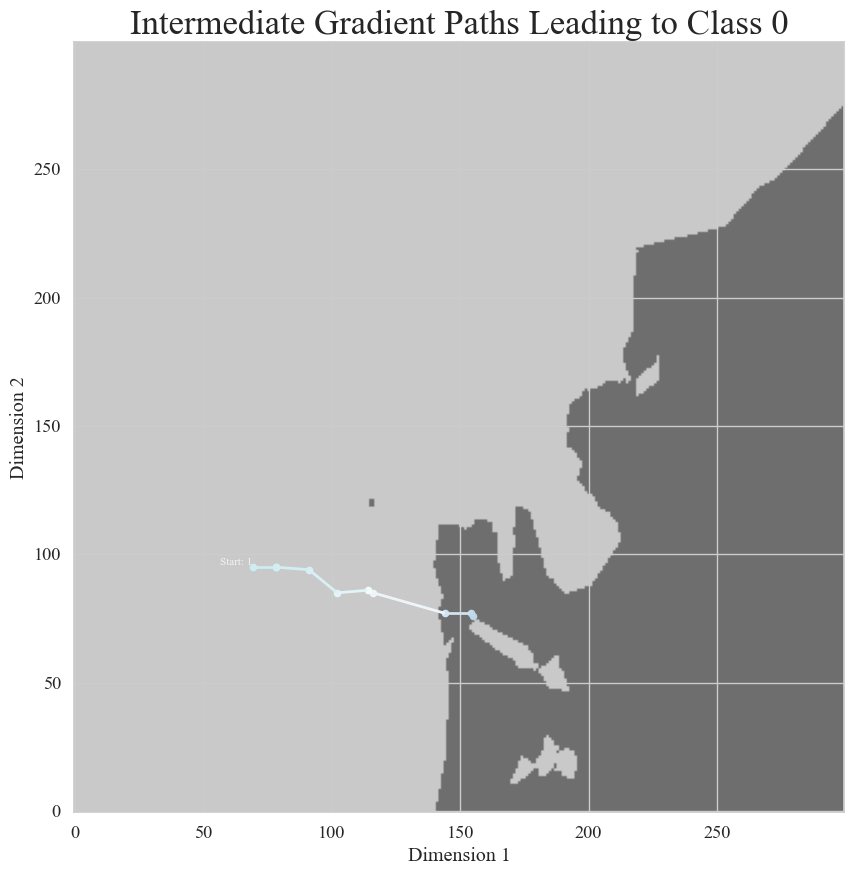

Class 0 paths overlay image saved as '../../../experiment_output/lamp/breast_cancer_newest_eval\class_0_paths_overlay_MLP.png'.
1/1 [==============================] - 0s 23ms/step


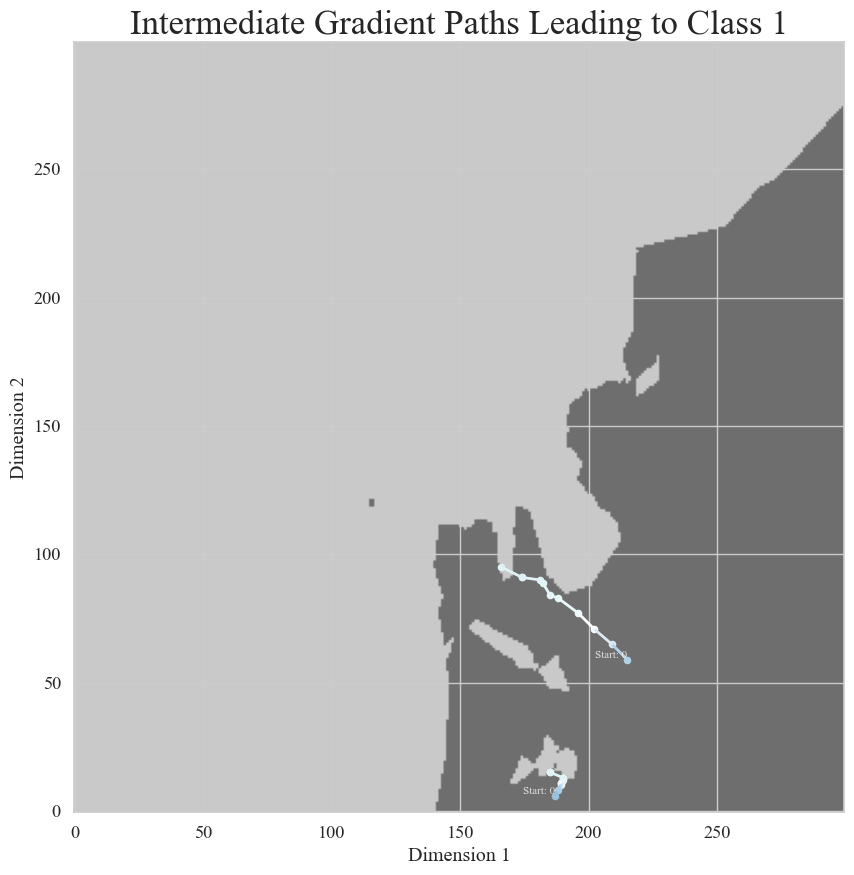

Class 1 paths overlay image saved as '../../../experiment_output/lamp/breast_cancer_newest_eval\class_1_paths_overlay_MLP.png'.


In [75]:
for i in range(2):
    pred_map.plot_class_paths(target_class=i, paths_dict=class_paths, path=path)

In [76]:
class_paths[1]['paths'][0][1:]

[[array([[0.22009037, 0.35083872, 0.24350145, 0.09299303, 0.9832325 ,
          0.80136126, 0.5556045 , 0.51286286, 0.7862626 , 1.01      ,
          0.12909108, 0.1858748 , 0.11665505, 0.02937564, 0.24145328,
          0.5532151 , 0.15295453, 0.363665  , 0.7381476 , 0.29720476,
          0.26698416, 0.3759275 , 0.26089275, 0.10780831, 0.93158805,
          0.8040117 , 0.53864217, 0.8748797 , 0.99      , 0.76371115]],
        dtype=float32)],
 [array([[0.22965752, 0.34128863, 0.2530632 , 0.08347293, 0.99213785,
          0.7917261 , 0.5460441 , 0.5033068 , 0.79563904, 1.0095084 ,
          0.11954637, 0.19556098, 0.10711101, 0.01983312, 0.23190196,
          0.562736  , 0.16249831, 0.37297788, 0.74756116, 0.30673832,
          0.25745073, 0.36638197, 0.25135258, 0.09826933, 0.9218869 ,
          0.7943533 , 0.529069  , 0.86530024, 0.9804031 , 0.7540728 ]],
        dtype=float32)],
 [array([[0.23895714, 0.33200365, 0.26235813, 0.07421764, 1.0008992 ,
          0.78234667, 0.5367483 , 0.

In [ ]:
trans = []
for point in class_paths[1]['paths'][1][1:]:
    new_point = point[0]
    trans.append(new_point[0])

trans_array = np.array(trans)

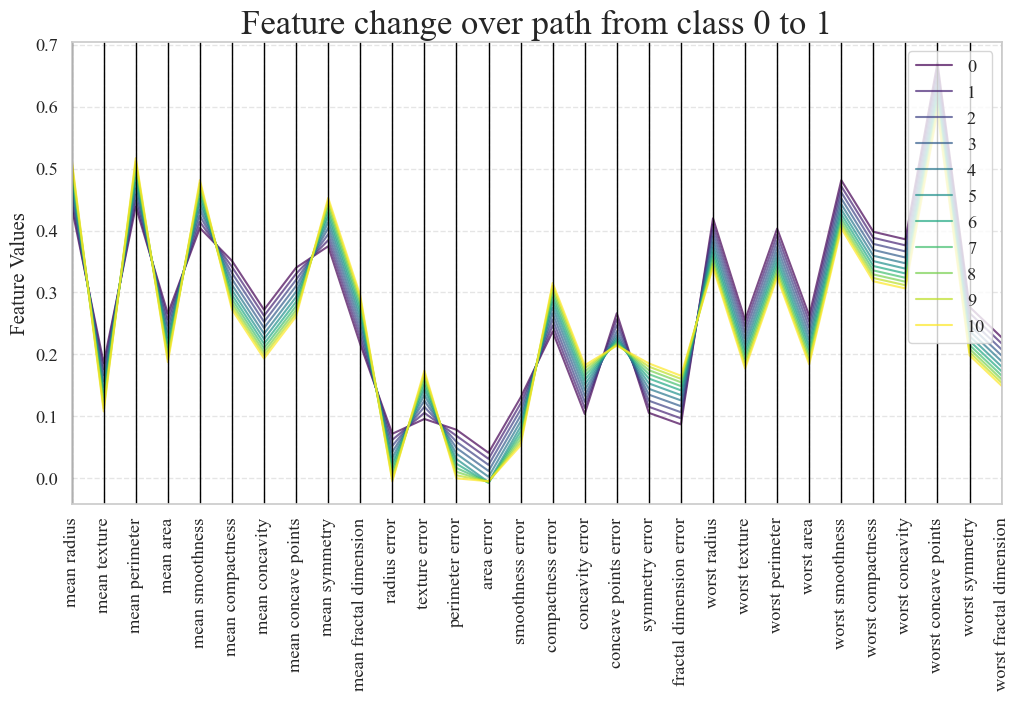

In [148]:
# Convert the data into a DataFrame
from pandas.plotting import parallel_coordinates

num_features = trans_array.shape[1]
df = pd.DataFrame(trans_array, columns=continuous_columns[:-1])
df['Class'] = range(len(df))  # Adding a class label for visualization

# Plot the parallel coordinates
plt.figure(figsize=(12, 6))
parallel_coordinates(df, class_column='Class', colormap=plt.cm.viridis, alpha=0.7)
plt.title("Feature change over path from class 0 to 1", fontsize=25)
plt.ylabel("Feature Values", fontsize=15)
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [81]:
from scipy.stats import entropy

def measure_intrinsic_dimensionality_pca(X: np.ndarray, threshold: float = 0.95) -> int:
    """
    Measures intrinsic dimensionality using PCA's cumulative variance approach.

    Parameters:
    ----------
    X : np.ndarray
        Input dataset.
    threshold : float
        Proportion of variance to retain.

    Returns:
    -------
    int
        Number of components needed to exceed `threshold` proportion of variance.
    """
    pca = PCA().fit(X)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    intrinsic_dim = np.argmax(cumulative_variance > threshold) + 1
    return intrinsic_dim


def compute_kl_divergence(X: np.ndarray, X_reference: np.ndarray, bins: int = 30) -> float:
    """
    Compute KL divergence between two distributions.

    Parameters:
    ----------
    X : np.ndarray
        First dataset.
    X_reference : np.ndarray
        Reference dataset.
    bins : int
        Number of bins for the histograms.

    Returns:
    -------
    float
        KL divergence value.
    """
    x_vals = X[:, 0]
    x_ref = X_reference[:, 0]

    data_min = min(x_vals.min(), x_ref.min())
    data_max = max(x_vals.max(), x_ref.max())
    bins_edges = np.linspace(data_min, data_max, bins + 1)

    hist_X, _ = np.histogram(x_vals, bins=bins_edges, density=True)
    hist_ref, _ = np.histogram(x_ref, bins=bins_edges, density=True)

    # Avoid zero values by adding a small constant
    hist_X = np.maximum(hist_X, 1e-9)
    hist_ref = np.maximum(hist_ref, 1e-9)

    kl_div = entropy(hist_X, hist_ref)
    return kl_div

4/4 [==============================] - 0s 5ms/step
Test points overlay image saved as '../../../experiment_output/lamp/breast_cancer_newest_eval\MLP_overlay_plot.png'.
Intrinsic dimensionality (PCA >=95% var): 10 (train), 7 (high-dim)
KL divergence (1D, feature[0]) between full data and train data: 0.1953


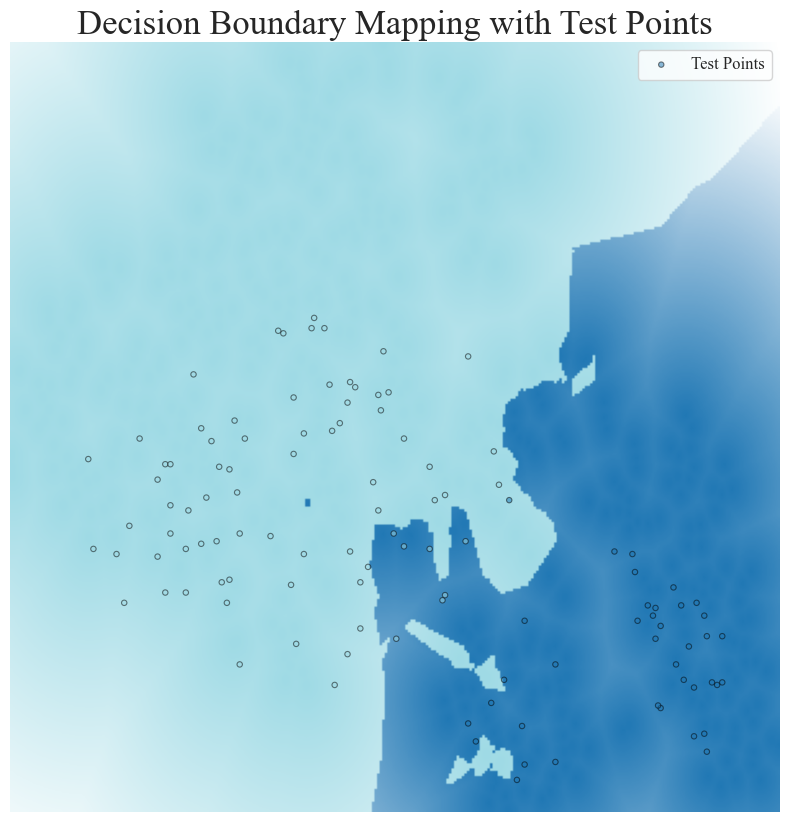

In [ ]:
output_path_train_test = '../../../results/experiment_output/breast_cancer_newest_eval'
classifier_name = 'MLP'

X_train = np.load("../../../data/experiment_input/breast_cancer/train_test_0/X_train.npy")
X_test = np.load("../../../data/experiment_input/breast_cancer/train_test_0/X_test.npy")

pred_map.plot_test_points_on_mapping(X_test, path=output_path_train_test)

df_results = pred_map.evaluate_mapping_testset(X_test)
accuracy = (df_results["pixel_label"] == df_results["original_label"]).mean()

X_high_dim_path = os.path.join(output_path_train_test, f'{classifier_name}_estimated_high_dim_points.csv')
X_high_dim = pd.read_csv(X_high_dim_path)
if isinstance(X_train, pd.DataFrame):
    X_reference = X_train.values
else:
    X_reference = X_train
X_high_dim = X_high_dim.values

# Intrinsic Dimensionality
dim_95_train = measure_intrinsic_dimensionality_pca(X_reference)
dim_95_high_dim = measure_intrinsic_dimensionality_pca(X_high_dim)
print(f"Intrinsic dimensionality (PCA >=95% var): {dim_95_train} (train), {dim_95_high_dim} (high-dim)")

# KL Divergence
kl_div = compute_kl_divergence(X_reference, X_high_dim, bins=30)
print(f"KL divergence (1D, feature[0]) between full data and train data: {kl_div:.4f}")

# Store results
results = {
    "classifier": classifier_name,
    "accuracy": accuracy,
    "dim_95_train": dim_95_train,
    "dim_95_high_dim": dim_95_high_dim,
    "kl_div": kl_div
}

results = pd.DataFrame([results])
results.to_csv(os.path.join(output_path_train_test, 'results.csv'), index=False)

In [83]:
pred_map.plot_data_with_predictions(path=path, grid_lines=False)

Plot saved as ../../../experiment_output/lamp/breast_cancer_newest_eval\MLP_predicted_points.png.


4/4 [==============================] - 0s 4ms/step
Test point 21 has a prediction probability of [0.47888103 0.52111894] and values: [0.49074731 0.45147109 0.46444613 0.33521545 0.29334469 0.13348874
 0.06773664 0.14100398 0.25454545 0.06550126 0.10472569 0.21145686
 0.08575602 0.07249064 0.13641772 0.06615195 0.03146465 0.14531161
 0.08763438 0.02360322 0.47301587 0.51839019 0.43484823 0.31809782
 0.35882633 0.11769557 0.09672524 0.28298969 0.17484723 0.06631248]
Test points overlay image saved as '../../../experiment_output/lamp/breast_cancer_newest_eval\MLP_overlay_plot.png'.


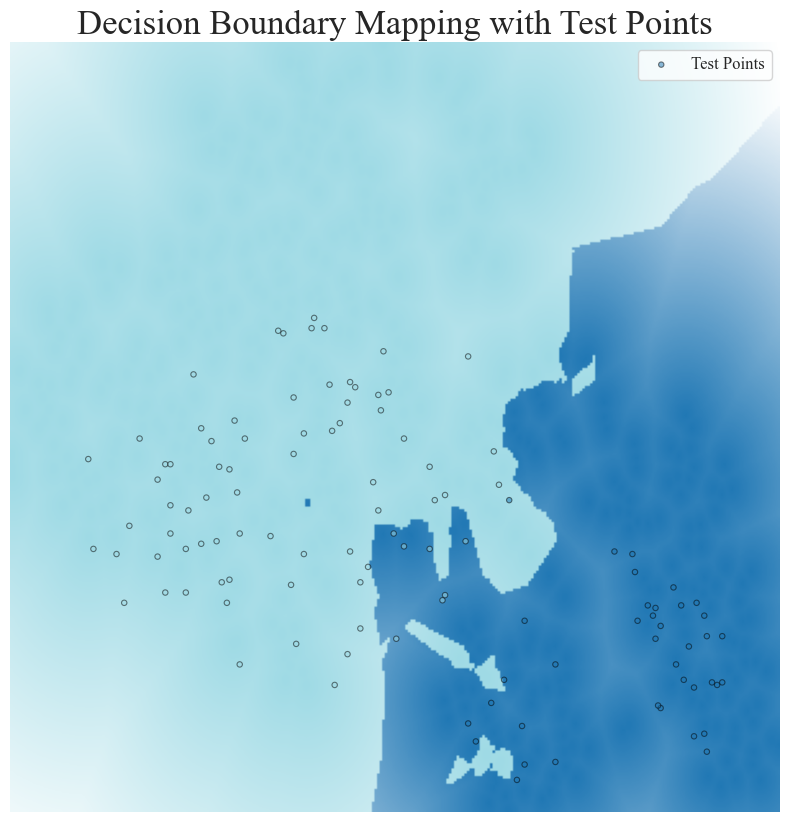

In [141]:
pred_map.plot_test_points_on_mapping(X_test, path=output_path_train_test)

In [143]:
x_new = np.array([0.49074731, 0.45147109, 0.46444613, 0.33521545, 0.29334469, 0.13348874,
 0.06773664, 0.14100398, 0.25454545, 0.06550126, 0.10472569, 0.21145686,
 0.08575602, 0.07249064, 0.13641772, 0.06615195, 0.03146465, 0.14531161,
 0.08763438, 0.02360322, 0.47301587, 0.51839019, 0.43484823, 0.31809782,
 0.35882633, 0.11769557, 0.09672524, 0.28298969, 0.17484723, 0.06631248]
).reshape(1, -1)
x_new_df = pd.DataFrame(x_new, columns=continuous_columns[:-1])
x_new_df.to_csv(os.path.join(path, 'x_new.csv'), index=False)

In [138]:
x_new = scaler.transform(x_new)

In [124]:
print(x_new)

[[-3.95897502e-01 -3.31361067e-01 -2.93658712e-01 -6.03379253e-02
  -1.30474222e+01 -1.45810455e+00  1.15038723e-01  9.42384699e-01
   1.94251908e+00 -3.79481842e+01  3.31363456e-01 -2.94247434e-02
   1.91439766e-02 -1.13768477e-02 -2.96679228e+01  7.52019381e-01
   7.12229905e-01  5.57351955e+00 -5.23712113e-01 -1.45218957e+01
  -2.64959640e-01 -3.20133412e-01 -2.74976823e-01 -5.66848338e-02
  -9.49548868e+00 -1.98456027e-01  1.85890689e-01  3.76414925e-01
  -4.99057031e-01 -7.09836983e+00]]


In [125]:
X_train[0]

array([0.15802925, 0.22455191, 0.14871122, 0.07701125, 0.38727339,
       0.09373658, 0.02371134, 0.02731113, 0.41666667, 0.25379107,
       0.03581387, 0.13410537, 0.0282241 , 0.01188902, 0.18264949,
       0.03751465, 0.02555556, 0.10409168, 0.10860021, 0.05911861,
       0.13174603, 0.25986141, 0.11576947, 0.06150671, 0.38939075,
       0.05930863, 0.03501597, 0.08182131, 0.21998817, 0.1242949 ])

In [112]:
import pickle
x_new = np.array([
    0.218426, 0.99676, 0.560103, 0.347422, 0.81623, 0.960233, 0.981544, 
    0.785021, 0.5581, 0.489427, 0.848642, 0.565255, 0.423081, 0.746013, 
    0.176473, 0.680542, 0.946498, 0.236534, 0.222161, 0.359583, 0.986238, 
    0.650099, 0.024367, 0.405964, 0.747938, 0.201479, 0.004371, 0.016538, 
    0.5146, 0.163112
]).reshape(1, -1)
# with open("../../../data/processed/input_data_comparison/hapiness/scaler.pkl", "rb") as f:
#     scaler = pickle.load(f)
x_new = scaler.transform(x_new)

In [90]:
x_new_df = pd.DataFrame(x_new, columns=continuous_columns[:-1])
x_new_df.to_csv(os.path.join(path, 'x_new.csv'), index=False)

1/1 [==============================] - 0s 31ms/step
Predicted class for the new datapoint: 1


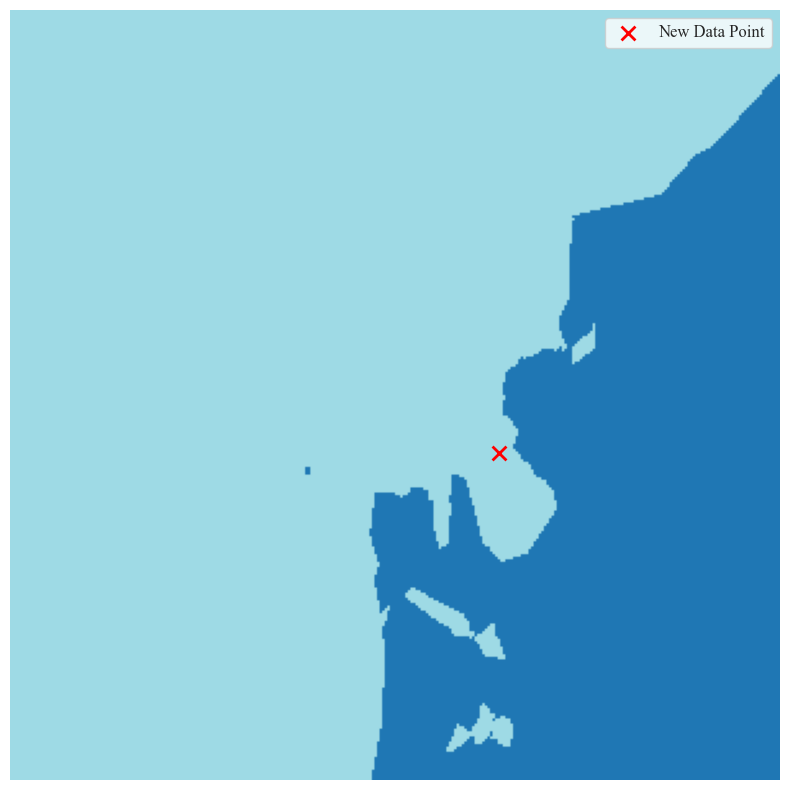

Prediction grid image with point saved as '../../../experiment_output/lamp/breast_cancer_newest_eval\MLP_new_point_plot.png'.


In [144]:
pred_map.plot_decision_boundary_with_new_point(x_new, path=path)

In [84]:
from VAE_DBS.visualization.plots import *

#Scatterplot for generated high-dimensional data
high_dim_original = pd.read_csv(os.path.join(path, '_original_0.csv'))
# high_dim_original['Binary Score'] = predictions_dataset_output
high_dim_intermediate = pd.read_csv(os.path.join(path, '_intermediate_gradients_0.csv'))
# high_dim_intermediate['Binary Score'] = intermediate_y_pred_output
high_dim_counterfactuals = pd.read_csv(os.path.join(path, '_counterfactuals_0.csv'))
high_dim_counterfactuals = high_dim_counterfactuals.drop(columns=['class']) if 'class' in high_dim_counterfactuals.columns else high_dim_counterfactuals
# high_dim_counterfactuals['Binary Score'] = cf_points_binary
combined_high_dim_data = pd.concat([high_dim_original, high_dim_intermediate, high_dim_counterfactuals], axis=0)
combined_high_dim_data = combined_high_dim_data.reset_index(drop=True)

In [85]:
combined_high_dim_data['label']

0      1
1      0
2      1
3      1
4      1
      ..
486    0
487    0
488    1
489    1
490    0
Name: label, Length: 491, dtype: int64

In [86]:
# Take a random sample of 5 rows from the breast cancer dataset
random_sample_features = bc.sample(n=7, axis=1, random_state=42)
print(random_sample_features)
random_sample_features['label'] = bc['label']

     worst concave points  compactness error  worst area  \
0                  0.2654            0.04904      2019.0   
1                  0.1860            0.01308      1956.0   
2                  0.2430            0.04006      1709.0   
3                  0.2575            0.07458       567.7   
4                  0.1625            0.02461      1575.0   
..                    ...                ...         ...   
564                0.2216            0.02891      2027.0   
565                0.1628            0.02423      1731.0   
566                0.1418            0.03731      1124.0   
567                0.2650            0.06158      1821.0   
568                0.0000            0.00466       268.6   

     concave points error  mean symmetry  mean fractal dimension  \
0                 0.01587         0.2419                 0.07871   
1                 0.01340         0.1812                 0.05667   
2                 0.02058         0.2069                 0.05999   
3      

In [8]:
high_dim_original = pd.read_csv(os.path.join(path, '_original_0.csv'))

Scatterplot matrix saved to ../../../experiment_output/lamp/breast_cancer_new_eval


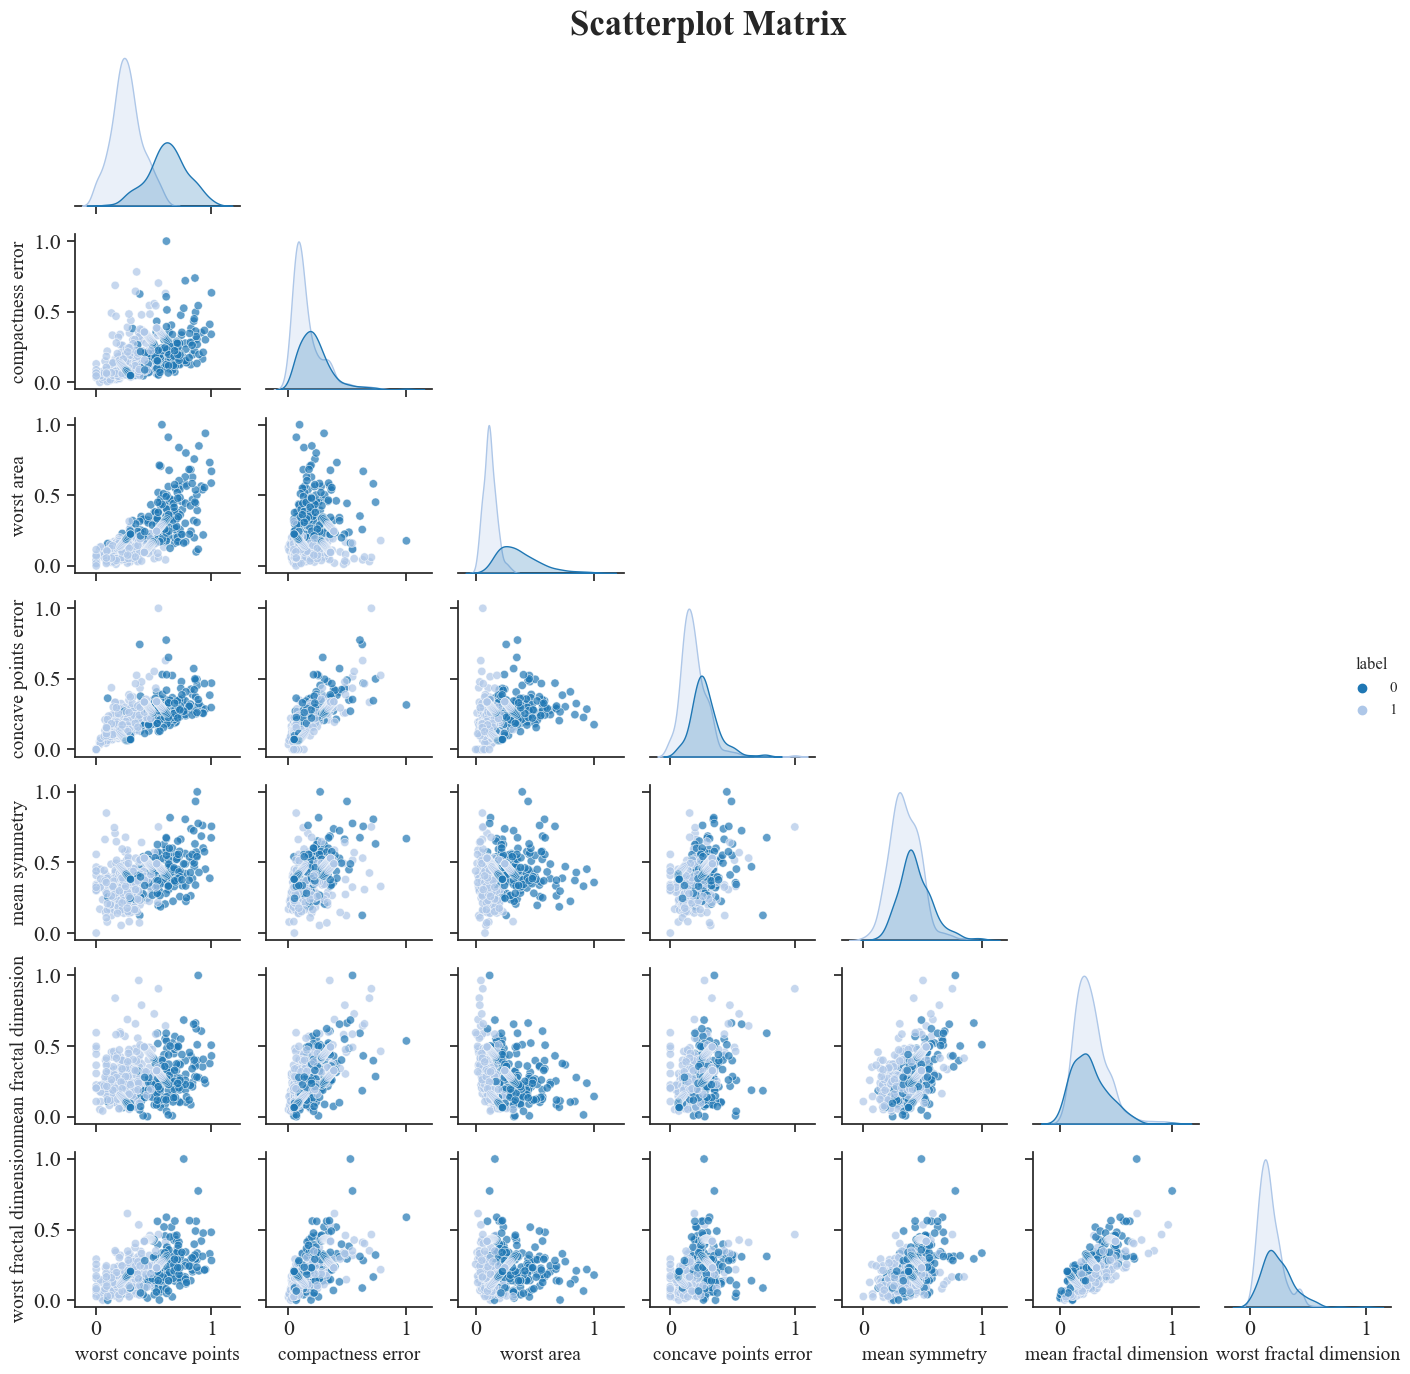

In [87]:
scatterplot_matrix(combined_high_dim_data, features=random_sample_features.columns, hue='label', save_path=path,  figsize=(14, 14), random_subset_size=None)

In [7]:
path = '../../../experiment_output/lamp/breast_cancer_new_eval'

In [14]:
two_features = bc[['worst area', 'compactness error', 'label']]
two_features.to_csv(os.path.join(path, 'two_features.csv'), index=False)

In [15]:
y = two_features['label']
X = two_features.drop(columns=['label']).values

In [ ]:
# Normalize features

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

os.makedirs("../../../data/experiment_input/two_features/train_test_0", exist_ok=True)

np.save("../../../data/experiment_input/two_features/train_test_0/X_train.npy", X_train)
np.save("../../../data/experiment_input/two_features/train_test_0/X_test.npy", X_test)
np.save("../../../data/experiment_input/two_features/train_test_0/y_train.npy", y_train)
np.save("../../../data/experiment_input/two_features/train_test_0/y_test.npy", y_test)

y_train_one_hot = to_categorical(y_train, num_classes=n_classes)
y_test_one_hot = to_categorical(y_test, num_classes=n_classes)

clf = Sequential([
        Dense(64, activation='relu', 
              input_shape=(X_train.shape[1],),
              kernel_regularizer=regularizers.l2(1e-4)),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-2)),
        Dense(2, activation='softmax')
    ])

start = time()
clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = clf.fit(
X_train, y_train_one_hot,
batch_size=5,
epochs=20,
validation_split=0.2)

output_dir = "../models/input_classifiers"
dataset_name = "two_features"
os.makedirs(os.path.join(output_dir, dataset_name), exist_ok=True)

loss, accuracy = clf.evaluate(X_test, y_test_one_hot, verbose=0)
# accuracy = clf.score(X_test, np.argmax(y_test_one_hot, axis=1))
# print(f"Accuracy on test data: {accuracy}")
print("\tAccuracy on test data: ", [loss, accuracy])
endtime = time() - start
with open(os.path.join(output_dir, dataset_name, f"MLP_0.txt"), "w") as f:
    f.write(f"Accuracy on test data: {[loss, accuracy]}\n")
    f.write(f"Finished training classifier... {endtime}\n")
model_save_path = os.path.join(output_dir, dataset_name, f"MLP_0.h5")
# dump(clf, model_save_path)
clf.save(model_save_path)
print(f"Model saved to {model_save_path}")

Epoch 1/20
73/73 [==============================] - 1s 10ms/step - loss: 1.0640 - accuracy: 0.6346 - val_loss: 0.8698 - val_accuracy: 0.6264
Epoch 2/20
73/73 [==============================] - 1s 7ms/step - loss: 0.7347 - accuracy: 0.7445 - val_loss: 0.6090 - val_accuracy: 0.8571
Epoch 3/20
73/73 [==============================] - 1s 7ms/step - loss: 0.5239 - accuracy: 0.8681 - val_loss: 0.4274 - val_accuracy: 0.9121
Epoch 4/20
73/73 [==============================] - 0s 7ms/step - loss: 0.4028 - accuracy: 0.8819 - val_loss: 0.3375 - val_accuracy: 0.9121
Epoch 5/20
73/73 [==============================] - 1s 7ms/step - loss: 0.3567 - accuracy: 0.8874 - val_loss: 0.3020 - val_accuracy: 0.9451
Epoch 6/20
73/73 [==============================] - 1s 7ms/step - loss: 0.3212 - accuracy: 0.9066 - val_loss: 0.2794 - val_accuracy: 0.9121
Epoch 7/20
73/73 [==============================] - 1s 7ms/step - loss: 0.3030 - accuracy: 0.9066 - val_loss: 0.2641 - val_accuracy: 0.9121
Epoch 8/20
73/73 [=

In [20]:
total_cfs = 1
# num_iterations = 2
# uncertain_points = [9, 18, 22, 28, 71]
# num_samples = len(uncertain_points)*num_iterations
# samples = uncertain_points*num_iterations
num_samples = 3
dice_cf = DiceCounterfactual(dataset_name='two_features', 
                             data_columns=two_features.columns,
                             model_name='two_features', 
                             outcome_name='label', 
                             preprocessing=None, 
                             backend='TF2', 
                             model_format='h5',
                            multi_class=True, 
                            comparison=False, 
                            comparison_method='train_test',
                            tt_number='0',
                            classifier_name='MLP',
                            comparison_data_name='two_features'
                            )

train_test
True
Epoch 1/50
2/2 [==============================] - 1s 445ms/step - loss: 0.8045 - val_loss: 0.7246
Epoch 2/50
2/2 [==============================] - 0s 124ms/step - loss: 0.7173 - val_loss: 0.6794
Epoch 3/50
2/2 [==============================] - 0s 54ms/step - loss: 0.6701 - val_loss: 0.6516
Epoch 4/50
2/2 [==============================] - 0s 67ms/step - loss: 0.6379 - val_loss: 0.6231
Epoch 5/50
2/2 [==============================] - 0s 61ms/step - loss: 0.6061 - val_loss: 0.5926
Epoch 6/50
2/2 [==============================] - 0s 66ms/step - loss: 0.5752 - val_loss: 0.5573
Epoch 7/50
2/2 [==============================] - 0s 56ms/step - loss: 0.5442 - val_loss: 0.5284
Epoch 8/50
2/2 [==============================] - 0s 48ms/step - loss: 0.5128 - val_loss: 0.4953
Epoch 9/50
2/2 [==============================] - 0s 52ms/step - loss: 0.4822 - val_loss: 0.4664
Epoch 10/50
2/2 [==============================] - 0s 53ms/step - loss: 0.4524 - val_loss: 0.4375
Epoch 11/50

In [21]:
counterfactuals, dataset, predictions_dataset, intermediate_y_pred, dice_data, cf_points_binary, sampled_indices, sampled_predictions, intermediate_points, instance_interest_idxs, counterfactual_idxs, all_gradients, gradient_instance_interest_idxs, gradient_counterfactual_idxs, iterations, class_paths = dice_cf.fit_transform_all_gradient(num_samples=num_samples, 
                                                                                                                                                                                                                                                                                                                                                    total_cfs=total_cfs, 
                                                                                                                                                                                                                                                                                                                                                    desired_class='opposite', 
                                                                                                                                                                                                                                                                                                                                                    prediction_weight=1.5, 
                                                                                                                                                                                                                                                                                                                                                    ae_weight=0.5, 
                                                                                                                                                                                                                                                                                                                                                    proto_weight=0.7, 
                                                                                                                                                                                                                                                                                                                                                    samples=None, 
                                                                                                                                                                                                                                                                                                                                                    learning_rate=0.01,
                                                                                                                                                                                                                                                                                                                                                    min_iter=10)

15/15 [==============================] - 0s 3ms/step
Sampled indices: [ 34  51 207]
Processing #0 instance 34... with prediction [0.96117383 0.03882619]
Generating counterfactuals for current class 0 and target class 1...
Generation of counterfactuals started...
Initial prediction for query instance: [0.7155202 0.2844798]
Target class defined: 1
step 1,  loss=1.93459
Converged because all CFs have reached the target class and probability.
Diverse Counterfactuals found! total time taken: 00 min 01 sec
Generation of counterfactuals completed.
Processing #1 instance 51... with prediction [0.9041394  0.09586064]
Generating counterfactuals for current class 0 and target class 1...
Generation of counterfactuals started...
Initial prediction for query instance: [0.69174254 0.30825743]
Target class defined: 1
step 1,  loss=1.80101
Converged because all CFs have reached the target class and probability.
Diverse Counterfactuals found! total time taken: 00 min 00 sec
Generation of counterfactuals

In [22]:
_, model_for_predictions = load_model_dice('TF2', model_name='two_features', tt_number='0', classifier_name='MLP', comparison_method_name=None)

None
True


In [ ]:
predictions_dataset_output = [np.argmax(x) for x in predictions_dataset]
intermediate_y_pred_output = [np.argmax(x) for x in intermediate_y_pred]
pred_map = create_map_embedding.PredictionMap(grid_size=300, 
                                              original_data=dataset, 
                                              intermediate_gradient_points=intermediate_points, 
                                              counterfactuals=counterfactuals, 
                                              all_gradients=all_gradients, 
                                              number_of_neighbors=3, 
                                              model_for_predictions=model_for_predictions, 
                                              projection_method='none', 
                                              projection_name='two_features', 
                                              intermediate_predictions=np.array(intermediate_y_pred_output), 
                                              original_predictions=np.array(predictions_dataset_output), 
                                              counterfactual_predictions=np.array(cf_points_binary), 
                                              outcome_name='label', 
                                              n_classes=2, 
                                              version='MLP', 
                                              comparison=False,
                                              dataset_name='two_features',
                                              gradients=False)

colormap: <matplotlib.colors.ListedColormap object at 0x000002DF08916DC0>


Original data projected to 2D.
Grid created.
Plot saved as ../../../experiment_output/lamp/breast_cancer_new_eval\MLP_predicted_points.png.
Plot saved as ../../../experiment_output/lamp/breast_cancer_new_eval\MLP_original_data_points.png.


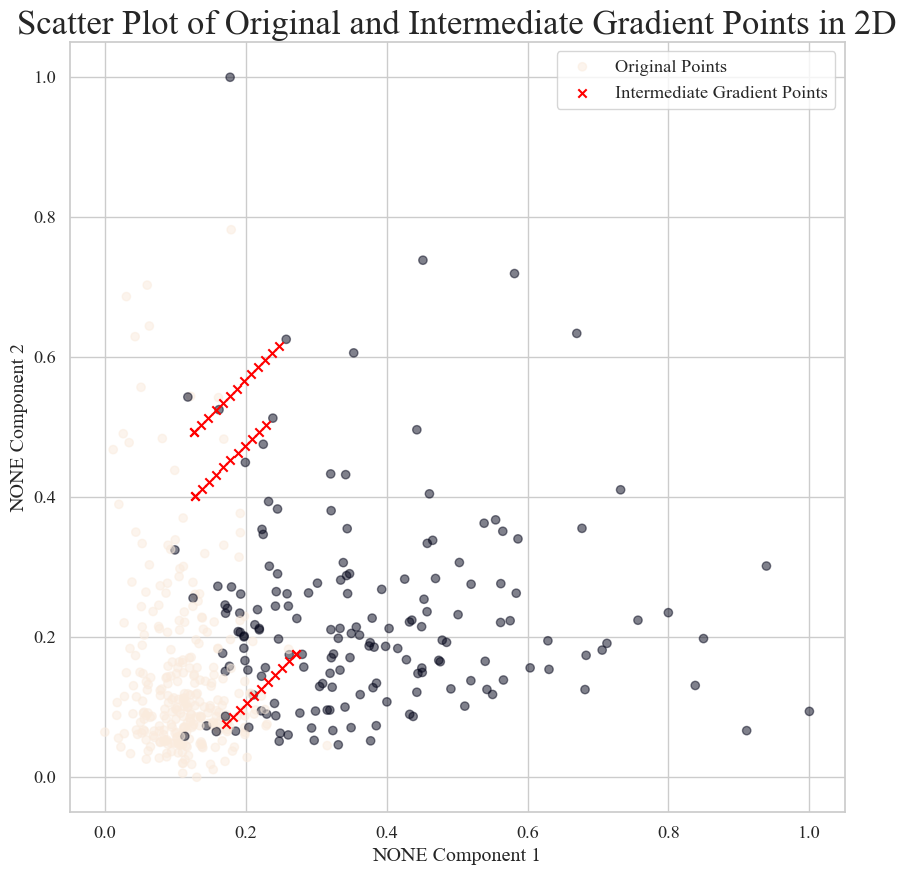

In [28]:
pred_map.fit_points_2D(path=path)

Constructing KDTree in NONE space with combined data...
KDTree constructed.
4/4 [==============================] - 0s 376us/step
Processed 0 / 90000 grid points.
4/4 [==============================] - 0s 5ms/step
Processed 1000 / 90000 grid points.
4/4 [==============================] - 0s 6ms/step
Processed 2000 / 90000 grid points.
4/4 [==============================] - 0s 3ms/step
Processed 3000 / 90000 grid points.
4/4 [==============================] - 0s 0s/step
Processed 4000 / 90000 grid points.
4/4 [==============================] - 0s 6ms/step
Processed 5000 / 90000 grid points.
4/4 [==============================] - 0s 5ms/step
Processed 6000 / 90000 grid points.
4/4 [==============================] - 0s 0s/step
Processed 7000 / 90000 grid points.
4/4 [==============================] - 0s 3ms/step
Processed 8000 / 90000 grid points.
4/4 [==============================] - 0s 6ms/step
Processed 9000 / 90000 grid points.
4/4 [==============================] - 0s 3ms/step
Proces

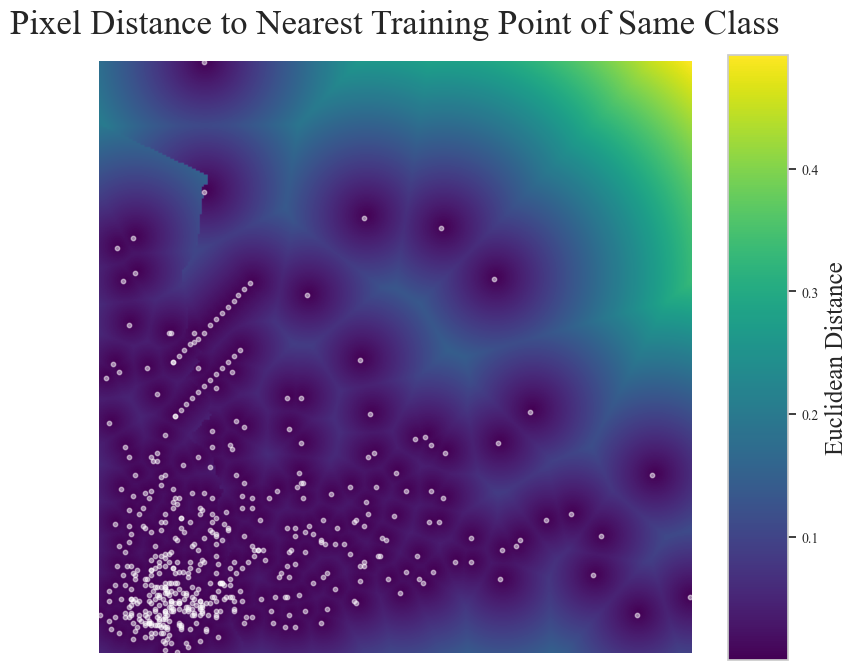

In [ ]:
pred_map.fit_grid_knn_weighted_interpolation(path=path)

In [30]:
pred_map.plot_original_data_points(path=path, grid_lines=False)

Plot saved as ../../../experiment_output/lamp/breast_cancer_new_eval\MLP_original_data_points.png.


In [89]:
predictions = pred_map.grid_predictions_prob

In [94]:
predictions.flatten().shape

(90000,)

In [ ]:
from VAE_DBS.visualization.plots import *

#Scatterplot for generated high-dimensional data
high_dim_data = pd.read_csv(os.path.join(path, 'MLP_estimated_high_dim_points.csv'))
high_dim_data['label'] = predictions.flatten()

scatterplot_matrix(high_dim_data, features=random_sample_features.columns, hue='label', save_path=path,  figsize=(14, 14), random_subset_size=None)

KeyboardInterrupt: 

: 

In [122]:
from VAE_DBS.visualization.plots import *

#Scatterplot for generated high-dimensional data
high_dim_original = pd.read_csv('../../../output_data/sampled_data/hapiness/hapiness_original_v1.csv')
# high_dim_original['Binary Score'] = predictions_dataset_output
# high_dim_intermediate = pd.read_csv('../../../output_data/sampled_data/hapiness/hapiness_intermediate_gradients_v1.csv')
# high_dim_intermediate['Binary Score'] = intermediate_y_pred_output
# high_dim_counterfactuals = pd.read_csv('../../../output_data/sampled_data/hapiness/hapiness_counterfactuals_v1.csv')
# high_dim_counterfactuals = high_dim_counterfactuals.drop(columns=['class']) if 'class' in high_dim_counterfactuals.columns else high_dim_counterfactuals
# high_dim_counterfactuals['Binary Score'] = cf_points_binary
# combined_high_dim_data = pd.concat([high_dim_original, high_dim_intermediate, high_dim_counterfactuals], axis=0)
# combined_high_dim_data = combined_high_dim_data.reset_index(drop=True)
scatterplot_matrix(high_dim_original, features=None, hue=None, save_path='../../../results/images/scatterplots/hapiness_scatterplots_original', figsize=(12, 12), random_subset_size=None)

KeyError: None

1/1 [==============================] - 0s 31ms/step
Predicted class for the new datapoint: 1
1/1 [==============================] - 0s 27ms/step


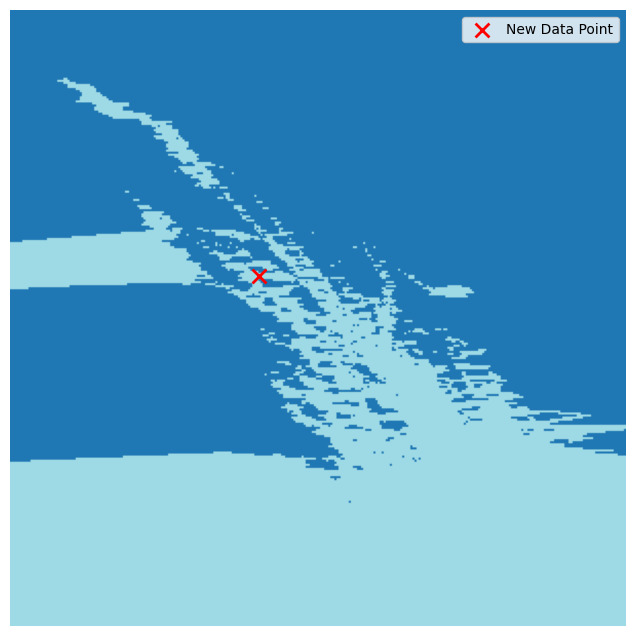

Prediction grid image with point saved as '../../../results/images/mapping_images/prediction_grid_image_with_point_hapiness_v4.png'.
